In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.scan_helper_functions import load_dataset, calculate_metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [4]:
version = '1'

In [5]:
#datafile = directory +'/aerosol_data/phase_data_noise_small.hdf5'
datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532_sc-None/test_dataset.hdf5'
datafile_training = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_P11_wl-532_sc-None/training_dataset.hdf5'

In [6]:
model_name = 'autoencoder1'


In [7]:
model_dir = directory +'/aerosol_results/simulated_data/autoencoder_models/'+model_name+'_dvar1'
model_dir

'/data/user/boiger_r/aerosol/aerosol_results/simulated_data/autoencoder_models/autoencoder1_dvar1'

In [8]:
#plot_dir = f'../plots/models/{model_name}'
plot_dir = model_dir+'/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [9]:
plot_dir

'/data/user/boiger_r/aerosol/aerosol_results/simulated_data/autoencoder_models/autoencoder1_dvar1/plots/model'

# Load the model and the data

In [10]:
autoencoder = keras.models.load_model(model_dir)
autoencoder

In [11]:
dir(autoencoder)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compile_was_called',
 '_compiled_tr

In [73]:
dvar_test = pd.read_hdf(datafile,key = 'dvar')
qoi_test = pd.read_hdf(datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)
dvar_training = pd.read_hdf(datafile_training,key = 'dvar')
qoi_training = pd.read_hdf(datafile_training,key = 'qoi')
dvar_training.reset_index(drop=True, inplace=True)
qoi_training.reset_index(drop=True, inplace=True)


In [74]:
dvar_test

n_532nm   k_532nm        V_tot  R_median       GSD
0      1.345160  0.060143  2315.678911  1.360143  1.422027
1      1.560918  0.172217  1121.450456  0.871451  1.422156
2      1.556752  0.179643  4962.553150  2.033473  1.405489
3      1.331706  0.039514  4874.291655  0.258148  1.404925
4      1.436442  0.118185  2536.972303  0.806500  1.444872
...         ...       ...          ...       ...       ...
19995  1.333477  0.047427  4764.529527  1.494872  1.414259
19996  1.468337  0.012928  3534.192530  1.835515  1.405211
19997  1.390257  0.042194  2015.697397  0.385029  1.430910
19998  1.563611  0.013500  3989.475902  1.355483  1.409619
19999  1.338385  0.098061  3102.600374  2.073354  1.426555

[20000 rows x 5 columns]

In [17]:
qoi_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       -15.346368   -15.647405   -15.970624   -16.311292   -16.653436   
1       -16.014276   -16.163742   -16.331920   -16.516203   -16.713155   
2       -15.012475   -15.523168   -16.036147   -16.531054   -16.993892   
3       -15.110576   -15.127886   -15.148264   -15.171547   -15.197773   
4       -15.174501   -15.305256   -15.452063   -15.612544   -15.783912   
...            ...          ...          ...          ...          ...   
19995   -14.684202   -15.030477   -15.398550   -15.783268   -16.160502   
19996   -15.173373   -15.617139   -16.067307   -16.508342   -16.909186   
19997   -15.379258   -15.411835   -15.449856   -15.493067   -15.541145   
19998   -14.784675   -15.078137   -15.392046   -15.719185   -16.045682   
19999   -15.515366   -16.027250   -16.539644   -17.031266   -17.492659   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -16.991183    -17.330672    -17.640897    -17.953306    -18.235696   
1        -16.921192    -17.137610    -17.357178    -17.592391    -17.812220   
2        -17.371364    -17.737432    -18.033515    -18.265816    -18.461357   
3        -15.226795    -15.258587    -15.293043    -15.331595    -15.369561   
4        -15.964517    -16.152045    -16.342427    -16.546712    -16.736172   
...             ...           ...           ...           ...           ...   
19995    -16.518349    -16.876763    -17.199644    -17.509242    -17.786276   
19996    -17.247239    -17.559565    -17.813364    -17.990783    -18.156242   
19997    -15.593900    -15.650971    -15.712164    -15.780053    -15.845553   
19998    -16.366749    -16.678024    -16.959743    -17.213962    -17.454191   
19999    -17.866221    -18.232874    -18.537709    -18.784121    -18.989895   

       ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  \
0      ...     -23.110124     -23.113011     -23.136928     -23.184647   
1      ...     -23.459839     -23.464077     -23.464821     -23.461755   
2      ...     -22.957258     -22.957445     -22.957538     -22.957538   
3      ...     -20.417253     -20.405321     -20.393602     -20.382090   
4      ...     -22.732734     -22.771907     -22.809611     -22.843529   
...    ...            ...            ...            ...            ...   
19995  ...     -22.322357     -22.292618     -22.286154     -22.309134   
19996  ...     -21.075977     -21.043402     -21.021699     -20.992087   
19997  ...     -21.247042     -21.256490     -21.263280     -21.266821   
19998  ...     -20.218619     -20.143847     -20.075221     -20.011886   
19999  ...     -24.145942     -24.140501     -24.139252     -24.143340   

       P11_0.532_170  P11_0.532_171  P11_0.532_172  P11_0.532_173  \
0         -23.255981     -23.346580     -23.446105     -23.537277   
1         -23.454866     -23.444477     -23.431206     -23.415891   
2         -22.957445     -22.957258     -22.956978     -22.956511   
3         -20.370920     -20.360152     -20.350048     -20.340592   
4         -22.871158     -22.890708     -22.901070     -22.902218   
...              ...            ...            ...            ...   
19995     -22.364401     -22.451150     -22.561802     -22.678580   
19996     -20.964141     -20.961168     -20.984072     -21.050160   
19997     -21.266735     -21.262851     -21.255332     -21.244681   
19998     -19.957240     -19.912869     -19.875939     -19.841442   
19999     -24.152955     -24.167193     -24.183767     -24.199392   

       P11_0.532_174  P11_0.532_175  
0         -23.598782     -23.614260  
1         -23.399570     -23.383355  
2         -22.956045     -22.955392  
3         -20.332035     -20.324423  
4         -22.895437     -22.882877  
...              ...            ...  
19995     -22.772372     -22.811788  
19996     -21.163198     -21.307003  
19997     -21.231761     -21.217743  
19998     -19.800357     -19.743550  
19999     -24.210446     -24.2143

In [15]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
dvar_test_scaled = min_max_scaler.fit_transform(dvar_test)
qoi_test_scaled = min_max_scaler.fit_transform(qoi_test)

In [18]:
qoi_test_scaled = pd.DataFrame(qoi_test_scaled, columns = qoi_test.columns)
qoi_test_scaled

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0         0.870904     0.851563     0.832394     0.813240     0.795207   
1         0.798686     0.798504     0.796968     0.793955     0.789781   
2         0.907006     0.864330     0.825969     0.792557     0.764277   
3         0.896399     0.904950     0.913029     0.920509     0.927453   
4         0.889487     0.886723     0.883241     0.879004     0.874203   
...            ...          ...          ...          ...          ...   
19995     0.942500     0.914960     0.888488     0.862936     0.839990   
19996     0.889609     0.854674     0.822914     0.794695     0.771972   
19997     0.867348     0.875771     0.883457     0.890249     0.896258   
19998     0.931637     0.910062     0.889125     0.868967     0.850421   
19999     0.852631     0.812530     0.776600     0.745479     0.718964   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0          0.777385      0.760392      0.744645      0.725412      0.708440   
1          0.783584      0.777094      0.768769      0.755685      0.743567   
2          0.743716      0.725201      0.711261      0.699199      0.689721   
3          0.933642      0.939655      0.944280      0.945317      0.946184   
4          0.868308      0.862359      0.855052      0.843395      0.832825   
...             ...           ...           ...           ...           ...   
19995      0.819260      0.799661      0.782164      0.762659      0.745719   
19996      0.754708      0.740589      0.729980      0.722268      0.715031   
19997      0.901131      0.905709      0.908643      0.907701      0.906701   
19998      0.832686      0.816855      0.802563      0.787427      0.773265   
19999      0.699891      0.682339      0.668390      0.655725      0.645879   

       ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  \
0      ...       0.621919       0.618691       0.613411       0.606333   
1      ...       0.595560       0.592382       0.589008       0.585858   
2      ...       0.633440       0.630348       0.626763       0.623114   
3      ...       0.824882       0.821601       0.817586       0.813412   
4      ...       0.650363       0.644252       0.637772       0.631538   
...    ...            ...            ...            ...            ...   
19995  ...       0.681293       0.680170       0.676731       0.671024   
19996  ...       0.775233       0.773784       0.770839       0.768340   
19997  ...       0.762340       0.757816       0.752859       0.748040   
19998  ...       0.839853       0.841196       0.841281       0.840766   
19999  ...       0.543848       0.541692       0.538813       0.535496   

       P11_0.532_170  P11_0.532_171  P11_0.532_172  P11_0.532_173  \
0           0.597598       0.587630       0.577251       0.567742   
1           0.583009       0.580501       0.578329       0.576471   
2           0.619495       0.615984       0.612636       0.609505   
3           0.809217       0.805127       0.801231       0.797616   
4           0.625824       0.620831       0.616681       0.613409   
...              ...            ...            ...            ...   
19995       0.662995       0.652843       0.641225       0.629491   
19996       0.765704       0.761356       0.755364       0.746591   
19997       0.743509       0.739385       0.735740       0.732603   
19998       0.839560       0.837702       0.835530       0.833510   
19999       0.531805       0.527866       0.523886       0.520129   

       P11_0.532_174  P11_0.532_175  
0           0.560637       0.557101  
1           0.574888       0.573548  
2           0.606616       0.604032  
3           0.794331       0.791436  
4           0.610952       0.609197  
...              ...            ...  
19995       0.619756       0.614261  
19996       0.734872       0.721447  
19997       0.729967       0.727805  
19998       0.832366       0.832812  
19999       0.516880       0.5143

In [19]:
dvar_test_scaled = pd.DataFrame(dvar_test_scaled, columns = dvar_test.columns)
dvar_test_scaled

n_532nm   k_532nm     V_tot  R_median       GSD
0      0.056134  0.304077  0.463155  0.514926  0.440500
1      0.855265  0.871187  0.224193  0.306941  0.443071
2      0.839832  0.908761  0.992789  0.801494  0.109711
3      0.006304  0.199693  0.975128  0.045922  0.098428
4      0.394227  0.597781  0.507436  0.279298  0.897434
...         ...       ...       ...       ...       ...
19995  0.012864  0.239736  0.953165  0.572267  0.285120
19996  0.512360  0.065163  0.706977  0.717243  0.104141
19997  0.223167  0.213255  0.403130  0.099922  0.618165
19998  0.865237  0.068061  0.798079  0.512943  0.192321
19999  0.031042  0.495950  0.620617  0.818467  0.531072

[20000 rows x 5 columns]

In [22]:

test_data = [dvar_test_scaled.values,qoi_test_scaled.values]
#test_data = [dvar_training.values,qoi_training.values]
#qoi_test = qoi_training
#dvar_test = dvar_training

In [23]:
test_data[1]

array([[0.87090376, 0.85156347, 0.83239416, ..., 0.56774198, 0.56063663,
        0.55710087],
       [0.79868644, 0.79850406, 0.79696808, ..., 0.57647087, 0.57488774,
        0.57354826],
       [0.9070059 , 0.8643302 , 0.82596948, ..., 0.60950486, 0.60661636,
        0.60403207],
       ...,
       [0.86734754, 0.87577092, 0.88345696, ..., 0.73260274, 0.72996709,
        0.72780509],
       [0.93163669, 0.91006211, 0.88912543, ..., 0.83350972, 0.83236592,
        0.83281202],
       [0.85263099, 0.81253012, 0.77660014, ..., 0.52012925, 0.51687984,
        0.51435444]])

# Predict

In [24]:
dvar1_pred_test = autoencoder.predict(test_data)
dvar2_pred_test = autoencoder.decoder(test_data[1])
qoi_pred_test = autoencoder.encoder(test_data[0])

In [25]:
qoi_pred_test = np.array(qoi_pred_test)
dvar2_pred_test = np.array(dvar2_pred_test)
dvar1_pred_test = pd.DataFrame(data=dvar1_pred_test, columns=dvar_test.columns)
qoi_pred_test = pd.DataFrame(data=qoi_pred_test, columns=qoi_test.columns)
dvar2_pred_test = pd.DataFrame(data=dvar2_pred_test, columns=dvar_test.columns)


In [28]:
dvar2_pred_test

n_532nm   k_532nm     V_tot  R_median       GSD
0      0.240548  0.446789  0.593808  0.541148  0.488516
1      0.542343  0.560402  0.532725  0.488279  0.456175
2      0.824072  0.442948  0.741411  0.729520  0.437393
3      0.298169  0.311879  0.533883  0.013544  0.492559
4      0.281589  0.567699  0.653612  0.298884  0.496091
...         ...       ...       ...       ...       ...
19995  0.293198  0.378219  0.737257  0.529801  0.484996
19996  0.509598  0.021756  0.524758  0.638508  0.546005
19997  0.314822  0.395755  0.519294  0.078904  0.498065
19998  0.777173  0.006033  0.715450  0.588749  0.487506
19999  0.382792  0.569898  0.532389  0.735681  0.480948

[20000 rows x 5 columns]

# Calculate metrics

In [29]:
#qoi_test = pd.DataFrame(data = qoi_test,columns=qoi_test.columns)
#dvar_test = pd.DataFrame(data = dvar_test,columns=dvar_test.columns)

In [30]:
dvar_test= dvar_test_scaled
qoi_test = qoi_test_scaled

In [31]:
dvar1_pred_test

n_532nm   k_532nm     V_tot  R_median       GSD
0      0.060627  0.302177  0.472145  0.512130  0.444666
1      0.858622  0.872223  0.227307  0.308923  0.441875
2      0.834095  0.884980  0.989214  0.788008  0.113759
3      0.012206  0.194396  0.979850  0.049132  0.111340
4      0.396589  0.598649  0.517670  0.276625  0.898876
...         ...       ...       ...       ...       ...
19995  0.021638  0.234110  0.963810  0.567543  0.290857
19996  0.514975  0.059856  0.714853  0.715583  0.112398
19997  0.228413  0.212694  0.415110  0.099991  0.622105
19998  0.868582  0.062404  0.807501  0.513504  0.198324
19999  0.038220  0.494271  0.628469  0.814622  0.534269

[20000 rows x 5 columns]

In [ ]:
qoi_test

In [32]:
res_qoi = qoi_test - qoi_pred_test
print(res_qoi)

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles_qoi = res_qoi.abs().quantile(q)
quantiles_qoi.to_csv(f'{plot_dir}/qoi_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

       P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0         0.002716     0.011978     0.016200    -0.000585     0.001999   
1         0.036912     0.032773     0.007226     0.010174     0.054829   
2        -0.055217    -0.037704    -0.056421    -0.025279     0.004191   
3        -0.065037    -0.039984    -0.026936    -0.038515    -0.045579   
4         0.021235    -0.005095    -0.001212     0.008268     0.000146   
...            ...          ...          ...          ...          ...   
19995    -0.035802    -0.018902    -0.014436    -0.018717    -0.031097   
19996    -0.040555    -0.007887    -0.018006    -0.020706    -0.000059   
19997     0.016145     0.011662     0.021078     0.010051     0.001653   
19998    -0.002717     0.010929    -0.000575    -0.006035     0.007614   
19999    -0.034211    -0.026270    -0.015254    -0.009410    -0.022886   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0          0.009854     -0.00961

In [33]:
res_dvar1 = dvar_test - dvar1_pred_test
quantiles_dvar1 = res_dvar1.abs().quantile(q)
quantiles_dvar1.to_csv(f'{plot_dir}/dvar1_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

In [34]:
metric_qoi = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])

r2_adj_qoi = metric_qoi.call(qoi_test.values, qoi_pred_test.values).numpy()
r2_adj_qoi = pd.Series(data=r2_adj_qoi, index=qoi_test.columns)
r2_adj_qoi = np.round(r2_adj_qoi, decimals=2)
r2_adj_qoi = pd.DataFrame(r2_adj_qoi).T

In [35]:
r2_adj_qoi

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0         0.93         0.94         0.96         0.99         0.97   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0          0.98          0.99          0.98          0.99          0.99  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0           0.98           0.99           0.96           0.99           0.99   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0           0.98           0.99           0.98           0.95           0.96  

[1 rows x 160 columns]

In [36]:
print(min(r2_adj_qoi.min()))
print(max(r2_adj_qoi.max()))

0.93
1.0


In [37]:
metric_dvar1 = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_dvar1 = metric_dvar1.call(dvar_test.values, dvar1_pred_test.values).numpy()
r2_adj_dvar1 = pd.Series(data=r2_adj_dvar1, index=dvar_test.columns)
r2_adj_dvar1 = np.round(r2_adj_dvar1, decimals=2)
r2_adj_dvar1 = pd.DataFrame(r2_adj_dvar1).T

In [38]:
r2_adj_dvar1

n_532nm  k_532nm  V_tot  R_median  GSD
0      1.0      1.0    1.0       1.0  1.0

In [39]:
print(min(r2_adj_dvar1.min()))
print(max(r2_adj_dvar1.max()))

1.0
1.0


In [41]:
metric_dvar2 = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_dvar2 = metric_dvar1.call(dvar_test.values, dvar2_pred_test.values).numpy()
r2_adj_dvar2 = pd.Series(data=r2_adj_dvar2, index=dvar_test.columns)
r2_adj_dvar2 = np.round(r2_adj_dvar2, decimals=2)
r2_adj_dvar2 = pd.DataFrame(r2_adj_dvar2).T
r2_adj_dvar2

n_532nm  k_532nm  V_tot  R_median   GSD
0      0.6     0.65   0.64      0.84 -0.02

In [42]:
rel_error_qoi = (qoi_pred_test - qoi_test) / qoi_test * 100.
rel_error_qoi = pd.DataFrame(rel_error_qoi, columns=qoi_test.columns).abs()
rel_error_qoi.reset_index(drop=True, inplace=True)
rel_error_qoi

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0         0.311884     1.406623     1.946192     0.071990     0.251329   
1         4.621527     4.104273     0.906741     1.281404     6.942323   
2         6.087876     4.362187     6.830867     3.189552     0.548392   
3         7.255344     4.418333     2.950192     4.184103     4.914385   
4         2.387334     0.574603     0.137204     0.940574     0.016672   
...            ...          ...          ...          ...          ...   
19995     3.798651     2.065860     1.624785     2.168979     3.702074   
19996     4.558711     0.922805     2.188085     2.605493     0.007680   
19997     1.861437     1.331641     2.385866     1.129051     0.184484   
19998     0.291673     1.200875     0.064660     0.694538     0.895348   
19999     4.012447     3.233128     1.964250     1.262279     3.183186   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0          1.267601      1.264281      1.052781      1.946417      2.008415   
1          2.242616      2.983560      1.901532      1.457706      0.242326   
2          6.051832      0.958824      9.276277      3.138688      1.192207   
3          0.396575      4.484253      0.501743      2.144912      0.018908   
4          1.342257      1.538672      1.372712      1.501090      0.545527   
...             ...           ...           ...           ...           ...   
19995      0.540305      3.667144      0.706381      3.683501      1.929860   
19996      0.601205      1.610987      2.778260      1.458762      0.171883   
19997      2.414354      0.208076      2.901689      1.249192      0.015147   
19998      0.031648      0.901350      1.803395      1.330135      0.343157   
19999      0.529051      1.082623      0.621105      0.992844      0.647005   

       ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  \
0      ...       1.395669       1.214871       2.102662       1.157146   
1      ...       5.583285       2.506339       0.969376       1.622960   
2      ...       2.416051       1.789428       0.409966       2.072476   
3      ...       5.601466       0.785379       1.895991       0.207638   
4      ...       2.929476       0.649008       1.862297       1.890285   
...    ...            ...            ...            ...            ...   
19995  ...       5.481752       1.477366       2.016330       0.682708   
19996  ...       3.058377       0.418282       2.817442       0.579236   
19997  ...       1.344153       1.050765       1.523509       0.489624   
19998  ...       0.974581       0.899334       0.878352       0.395300   
19999  ...       3.770891       2.229933       0.211664       0.891010   

       P11_0.532_170  P11_0.532_171  P11_0.532_172  P11_0.532_173  \
0           1.580770       0.242773       0.746411       1.458800   
1           0.249686       1.306076       0.292092       2.140479   
2           1.448784       4.583969       3.761897       3.754883   
3           3.068575       5.472010       1.918163       3.998357   
4           2.558207       2.102623       1.996155       3.396384   
...              ...            ...            ...            ...   
19995       0.723669       2.992696       0.318899       0.249768   
19996       1.267335       0.198798       0.119005       0.835159   
19997       0.807991       0.395695       0.018330       1.945334   
19998       1.631961       2.426140       1.147482       2.746472   
19999       1.093955       1.186443       0.652789       0.390411   

       P11_0.532_174  P11_0.532_175  
0           0.160589       1.073868  
1           4.141915       3.496729  
2           0.275990       6.014291  
3           4.968618       9.588018  
4           2.515240       6.249788  
...              ...            ...  
19995       0.690514       3.992204  
19996       3.462589       1.514183  
19997       0.025126       0.818789  
19998       0.133131       3.140096  
19999       5.592630       4.9747

In [43]:
rel_error_dvar1 = (dvar1_pred_test - dvar_test) / dvar_test * 100.
rel_error_dvar1 = pd.DataFrame(rel_error_dvar1, columns=dvar_test.columns).abs()
rel_error_dvar1.reset_index(drop=True, inplace=True)
rel_error_dvar1

n_532nm   k_532nm     V_tot  R_median        GSD
0       8.003942  0.624782  1.940986  0.543123   0.945699
1       0.392464  0.118964  1.388883  0.645549   0.269906
2       0.683091  2.616949  0.360166  1.682562   3.689053
3      93.639375  2.652756  0.484223  6.990771  13.118198
4       0.599026  0.145189  2.016841  0.957136   0.160681
...          ...       ...       ...       ...        ...
19995  68.212830  2.346744  1.116752  0.825454   2.012011
19996   0.510283  8.145079  1.113928  0.231532   7.928555
19997   2.350702  0.263020  2.971805  0.069281   0.637317
19998   0.386535  8.312163  1.180644  0.109425   3.121139
19999  23.124219  0.338509  1.265221  0.469785   0.601963

[20000 rows x 5 columns]

In [45]:
rel_error_dvar2 = (dvar2_pred_test - dvar_test) / dvar_test * 100.
rel_error_dvar2 = pd.DataFrame(rel_error_dvar2, columns=dvar_test.columns).abs()
rel_error_dvar2.reset_index(drop=True, inplace=True)
rel_error_dvar2

n_532nm    k_532nm       V_tot   R_median         GSD
0       328.522284  46.932852   28.209243   5.092306   10.900481
1        36.587720  35.673736  137.619206  59.078957    2.957449
2         1.876595  51.258002   25.320359   8.979939  298.676803
3      4630.117718  56.179019   45.249987  70.505394  400.425361
4        28.571804   5.032207   28.806811   7.012604   44.721184
...            ...        ...         ...        ...         ...
19995  2179.300124  57.765188   22.651730   7.420573   70.102186
19996     0.539089  66.613272   25.774459  10.977537  424.292861
19997    41.070360  85.578570   28.815511  21.034578   19.428552
19998    10.178030  91.136494   10.353379  14.778590  153.484817
19999  1133.157513  14.910382   14.216157  10.114757    9.438310

[20000 rows x 5 columns]

In [46]:
rel_error_table_qoi = np.round(rel_error_qoi.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_qoi

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
50%         2.19         2.22         1.89         1.04         1.87   
75%         3.96         3.90         3.20         1.83         3.21   
90%         6.19         5.74         4.78         2.82         4.64   
95%         7.85         7.13         5.99         3.57         5.63   
99%        13.28        10.44         8.92         8.21         8.21   

     P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
50%          1.25          0.86          1.42          1.16          0.93   
75%          2.22          1.53          2.49          2.00          1.68   
90%          3.39          2.32          3.69          2.98          2.49   
95%          4.33          2.92          4.64          3.67          3.02   
99%          7.30          5.97          7.94          6.49          9.38   

     ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  \
50%  ...           1.98           1.08           2.62           1.51   
75%  ...           3.39           1.88           4.43           2.57   
90%  ...           4.94           2.73           6.34           3.68   
95%  ...           6.10           3.46           7.72           4.51   
99%  ...           8.97           6.86          11.51           6.37   

     P11_0.532_170  P11_0.532_171  P11_0.532_172  P11_0.532_173  \
50%           1.18           1.60           1.24           2.02   
75%           2.11           2.79           2.09           3.46   
90%           3.16           4.20           3.05           4.95   
95%           3.97           5.26           3.85           6.13   
99%           9.17          15.50           8.49          10.28   

     P11_0.532_174  P11_0.532_175  
50%           2.79           2.73  
75%           4.80           4.64  
90%           7.00           6.66  
95%           8.53           8.09  
99%          12.33          12.28  

[5 rows x 160 columns]

In [47]:
rel_error_table_qoi.min(axis = 1)

50%    0.35
75%    0.63
90%    1.09
95%    1.58
99%    3.42
dtype: float64

In [48]:
rel_error_table_qoi.max(axis = 1)

50%     2.88
75%     4.81
90%     7.00
95%     8.53
99%    17.74
dtype: float64

In [49]:
rel_error_table_dvar1 = np.round(rel_error_dvar1.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_dvar1

n_532nm  k_532nm  V_tot  R_median    GSD
50%     0.79     0.75   1.60      0.46   0.67
75%     1.68     2.10   2.38      0.83   1.95
90%     4.61     8.30   3.38      2.00   6.74
95%     9.86    19.35   5.45      4.21  14.46
99%    56.07   103.17  85.72     26.79  89.76

In [50]:
rel_error_table_dvar1.min(axis = 1)

50%     0.46
75%     0.83
90%     2.00
95%     4.21
99%    26.79
dtype: float64

In [51]:
rel_error_table_dvar1.max(axis = 1)

50%      1.60
75%      2.38
90%      8.30
95%     19.35
99%    103.17
dtype: float64

In [52]:
rel_error_table_dvar2 = np.round(rel_error_dvar2.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_dvar2

n_532nm  k_532nm    V_tot  R_median      GSD
50%    21.62    30.79    28.09     17.04    42.45
75%    65.01    59.18    65.28     29.51    89.01
90%   223.69   131.10   147.33     52.60   358.41
95%   491.61   336.57   214.86     79.26   811.92
99%  2737.04  1717.49  1650.37    258.64  5154.99

In [53]:
rel_error_table_dvar2.min(axis = 1)

50%     17.04
75%     29.51
90%     52.60
95%     79.26
99%    258.64
dtype: float64

In [54]:
rel_error_table_dvar2.max(axis = 1)

50%      42.45
75%      89.01
90%     358.41
95%     811.92
99%    5154.99
dtype: float64

# Save $\bar{R}^2$

In [55]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

In [56]:
r2_adj_T_qoi = r2_adj_qoi.T
r2_adj_T_qoi=r2_adj_T_qoi.rename(columns={0: "r2_adj"})
r2_adj_T_qoi

r2_adj
P11_0.532_5      0.93
P11_0.532_6      0.94
P11_0.532_7      0.96
P11_0.532_8      0.99
P11_0.532_9      0.97
...               ...
P11_0.532_171    0.98
P11_0.532_172    0.99
P11_0.532_173    0.98
P11_0.532_174    0.95
P11_0.532_175    0.96

[160 rows x 1 columns]

In [57]:
r2_adj_T_qoi.min()

r2_adj    0.93
dtype: float64

In [58]:
r2_adj_T_dvar1 = r2_adj_dvar1.T
r2_adj_T_dvar1=r2_adj_T_dvar1.rename(columns={0: "r2_adj"})
r2_adj_T_dvar1

r2_adj
n_532nm      1.0
k_532nm      1.0
V_tot        1.0
R_median     1.0
GSD          1.0

# Plot

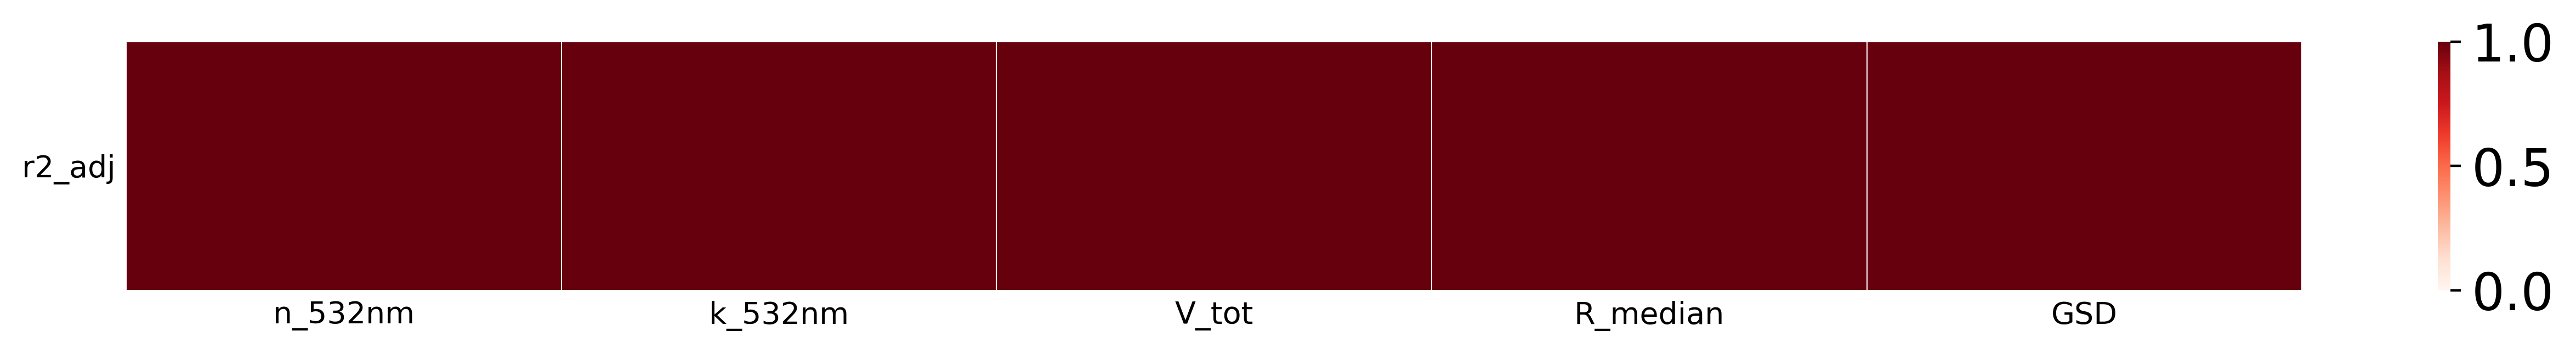

In [59]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T_dvar1, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_model_r2_adj_dvar1.jpg')


In [60]:
r2_adj_T_dvar1

r2_adj
n_532nm      1.0
k_532nm      1.0
V_tot        1.0
R_median     1.0
GSD          1.0

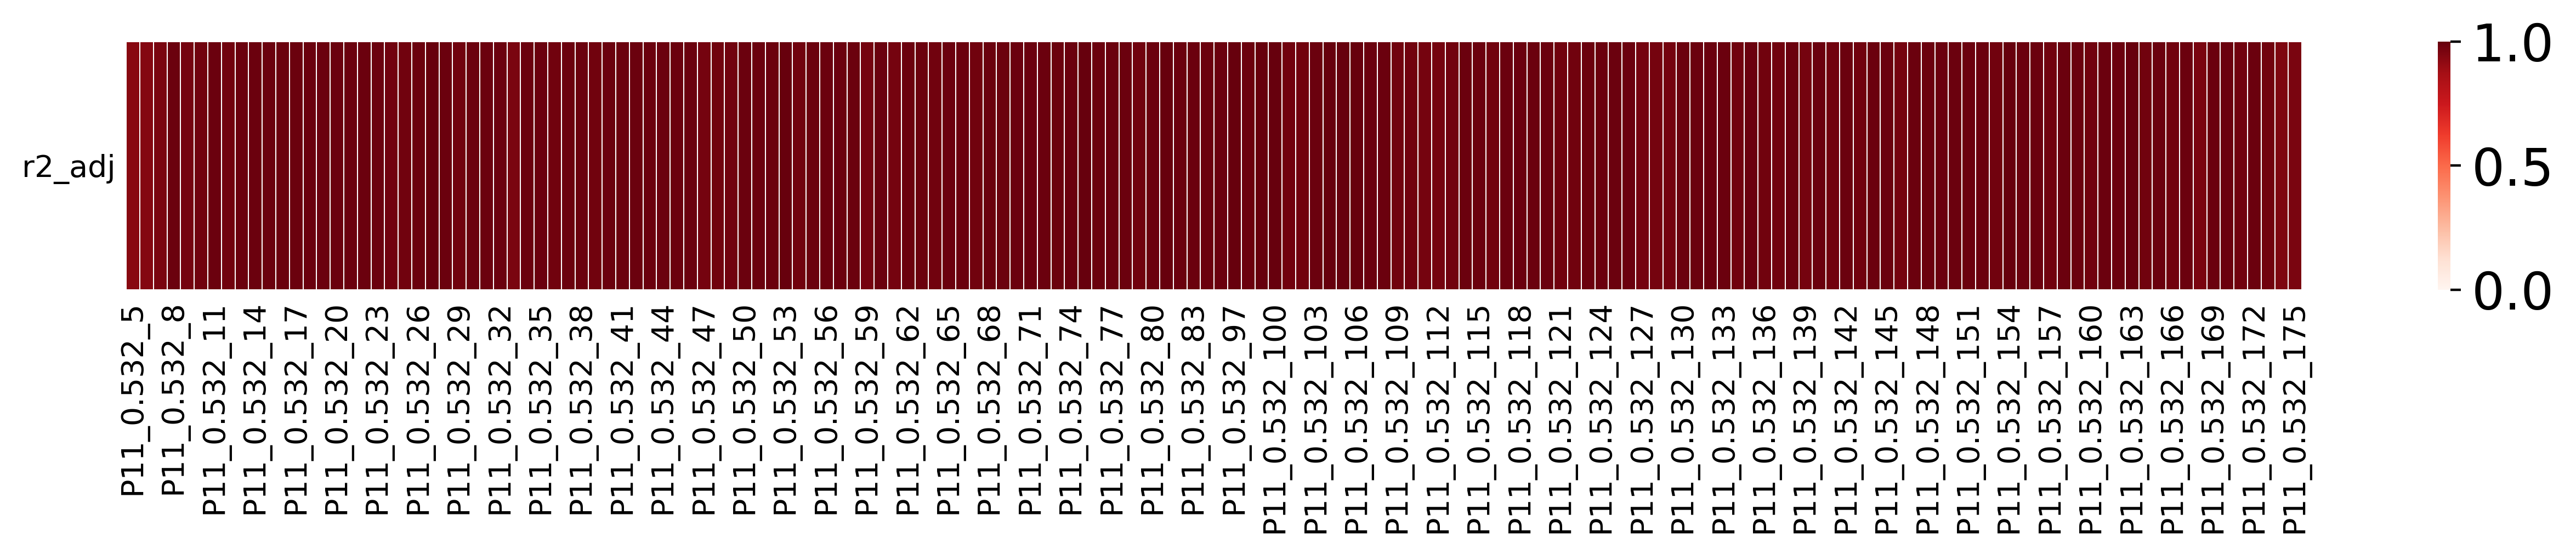

In [61]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(pd.DataFrame(r2_adj_T_qoi, columns = ['r2_adj']).T,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_model_r2_adj_qoi.jpg')


## Relative Errors

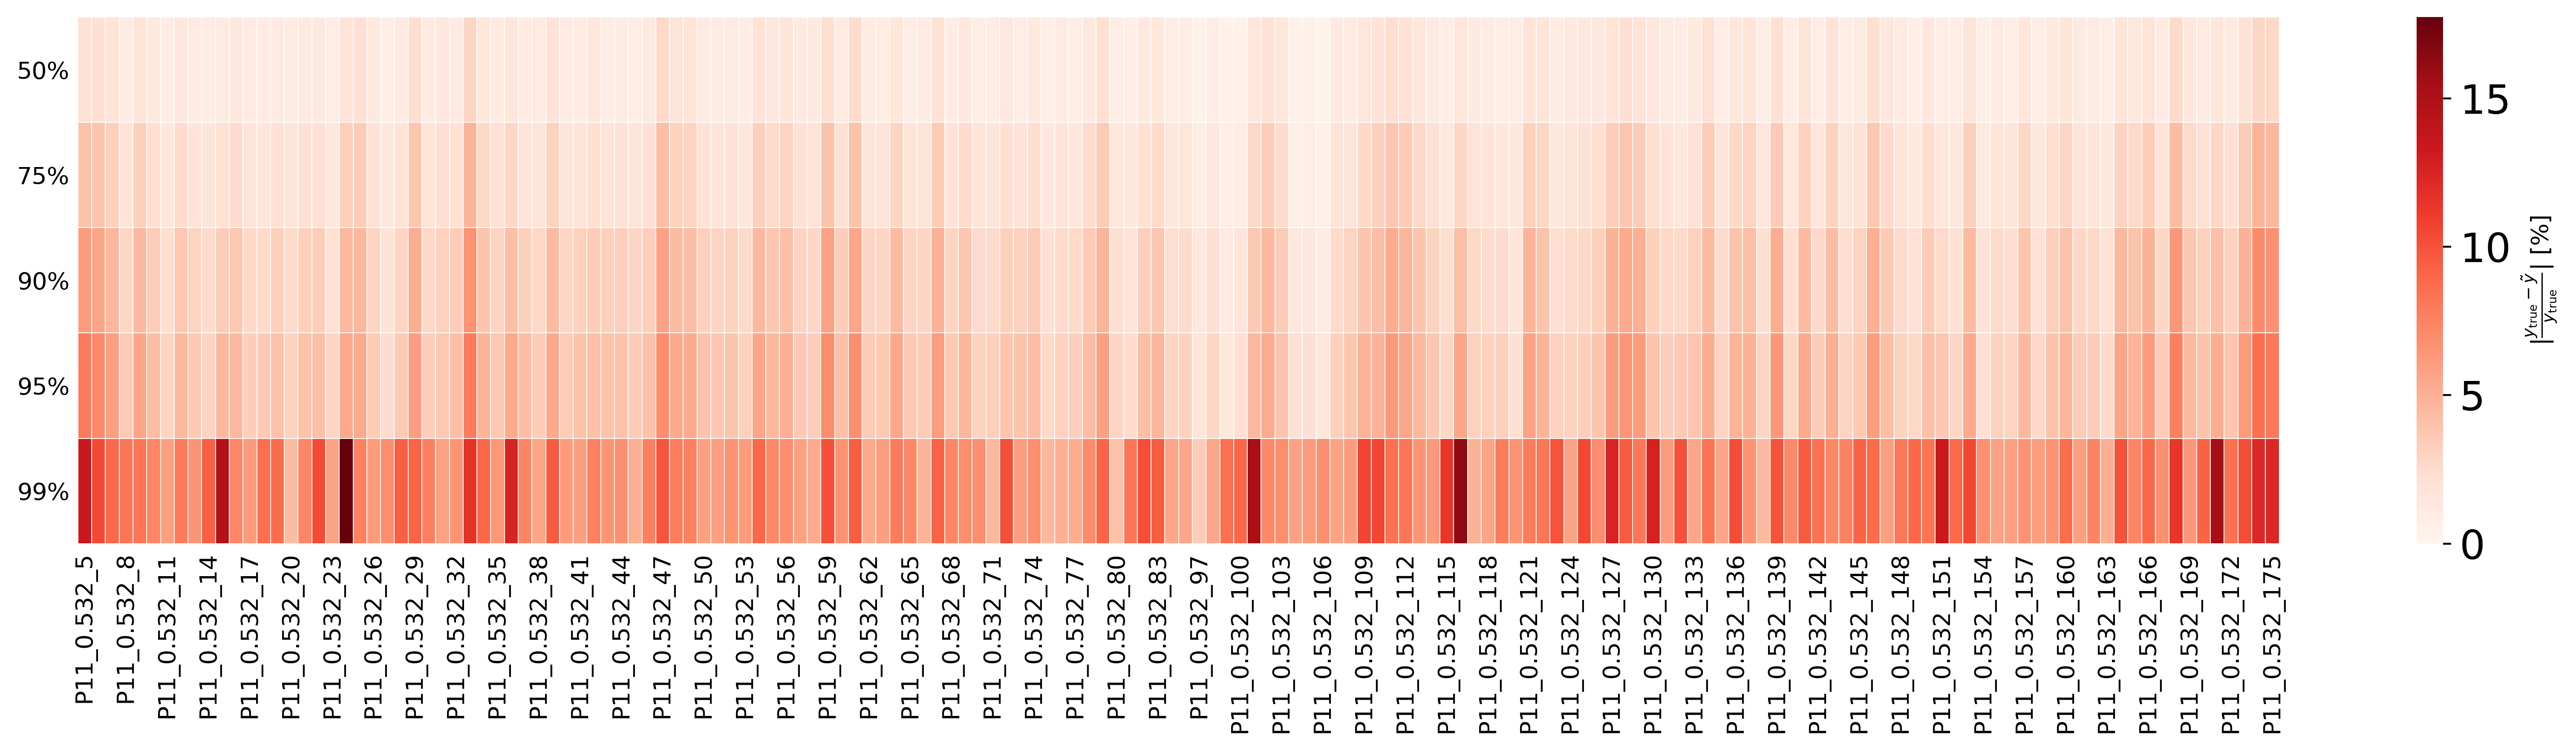

In [62]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_qoi,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table_qoi.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_rel_error_percentiles_qoi.jpg')

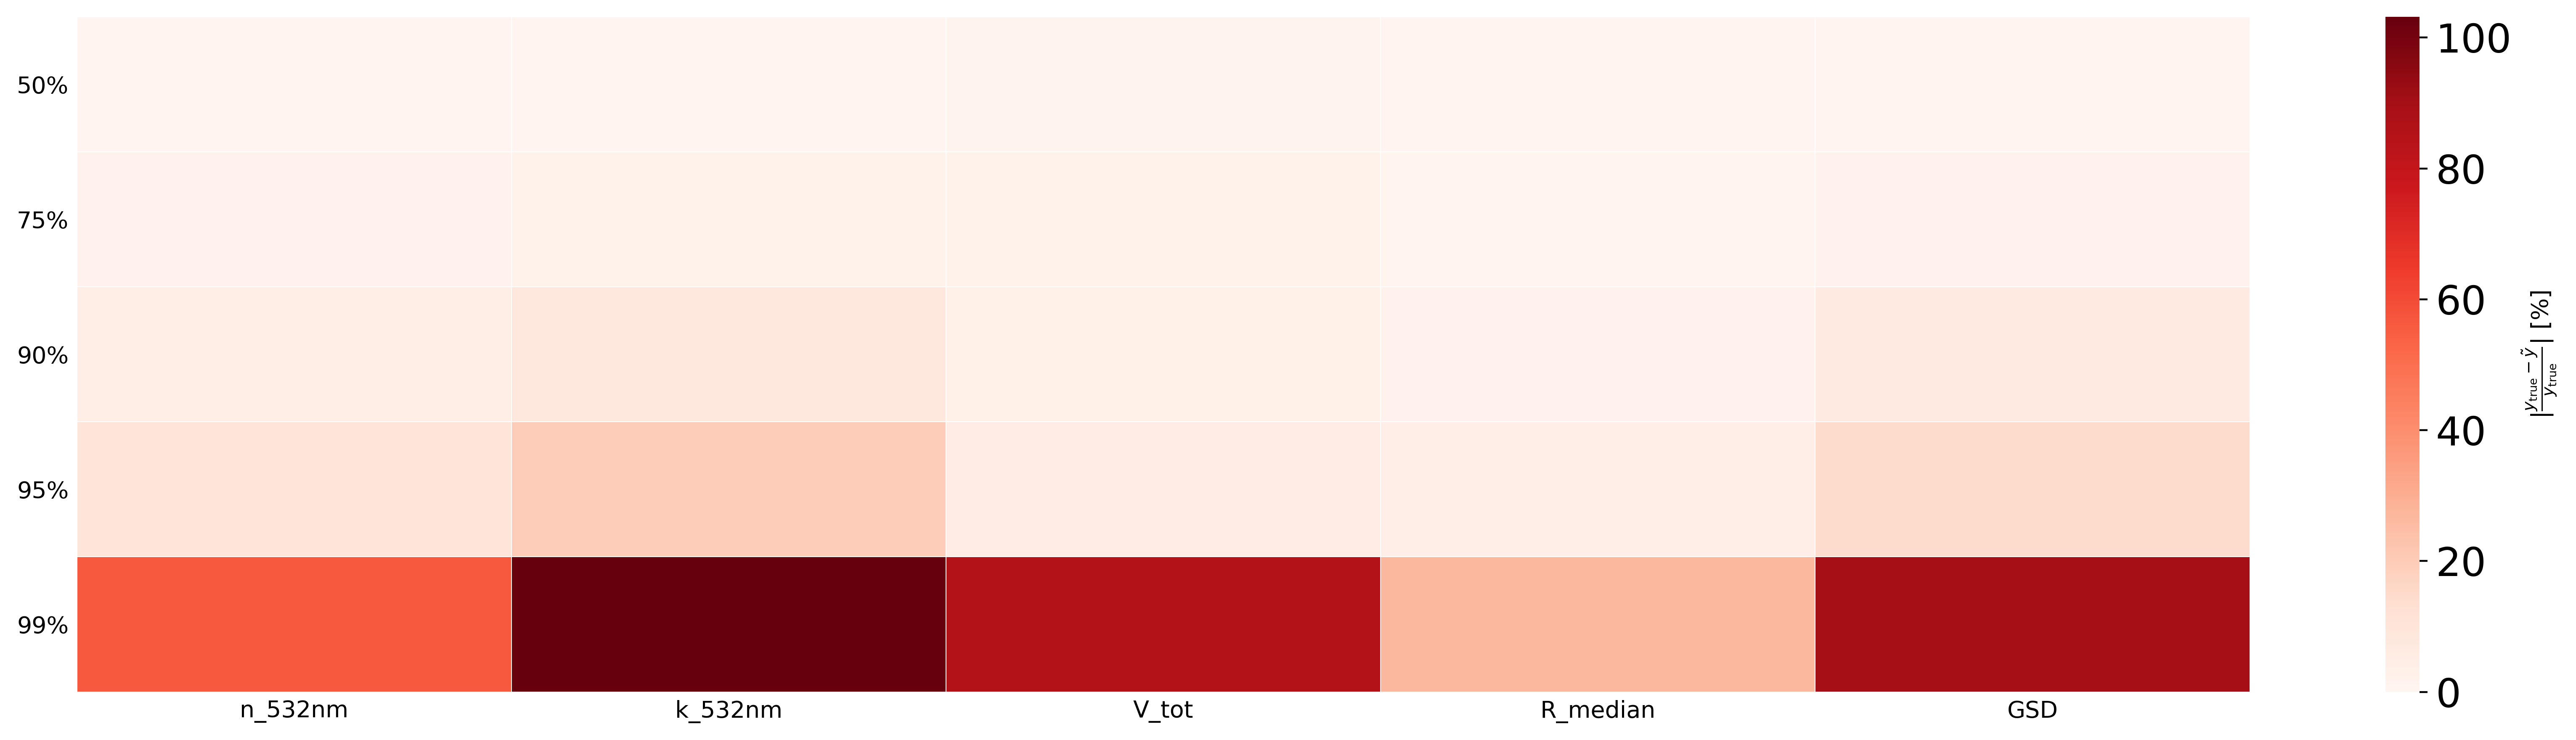

In [63]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_dvar1,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table_dvar1.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/autoencoder_rel_error_percentiles_dvar1.jpg')

## Correlations between DVARs and QOIs

In [64]:
combined = pd.concat([dvar_test, rel_error_qoi], axis=1)

In [65]:
corr = np.round(combined.corr(), decimals=2)

In [66]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [67]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [68]:
to_plot

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
n_532nm          0.00        -0.01        -0.02        -0.03        -0.04   
k_532nm          0.00         0.03         0.05         0.03         0.06   
V_tot           -0.15        -0.09        -0.08        -0.17        -0.07   
R_median         0.12         0.09         0.07         0.08         0.06   
GSD              0.00        -0.02        -0.01        -0.03         0.00   

          P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  \
n_532nm          -0.02         -0.03         -0.04         -0.02   
k_532nm           0.11          0.02          0.11         -0.04   
V_tot            -0.12         -0.12         -0.15         -0.14   
R_median          0.03          0.05          0.07          0.09   
GSD              -0.02         -0.02          0.08         -0.01   

          P11_0.532_14  ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
n_532nm          -0.00  ...          -0.02          -0.01          -0.01   
k_532nm          -0.01  ...           0.01           0.01           0.03   
V_tot            -0.20  ...          -0.02          -0.05          -0.07   
R_median          0.10  ...           0.04           0.02           0.04   
GSD              -0.04  ...          -0.01           0.01          -0.06   

          P11_0.532_169  P11_0.532_170  P11_0.532_171  P11_0.532_172  \
n_532nm            0.01          -0.01           0.00           0.01   
k_532nm           -0.01          -0.00           0.02          -0.00   
V_tot             -0.02          -0.07          -0.11          -0.04   
R_median           0.03          -0.00           0.03           0.00   
GSD                0.01           0.02          -0.00           0.00   

          P11_0.532_173  P11_0.532_174  P11_0.532_175  
n_532nm            0.00           0.00          -0.01  
k_532nm            0.00           0.00           0.01  
V_tot             -0.03          -0.02          -0.02  
R_median           0.01           0.01           0.01  
GSD                0.01          -0.00           0.01  

[5 rows x 160 columns]

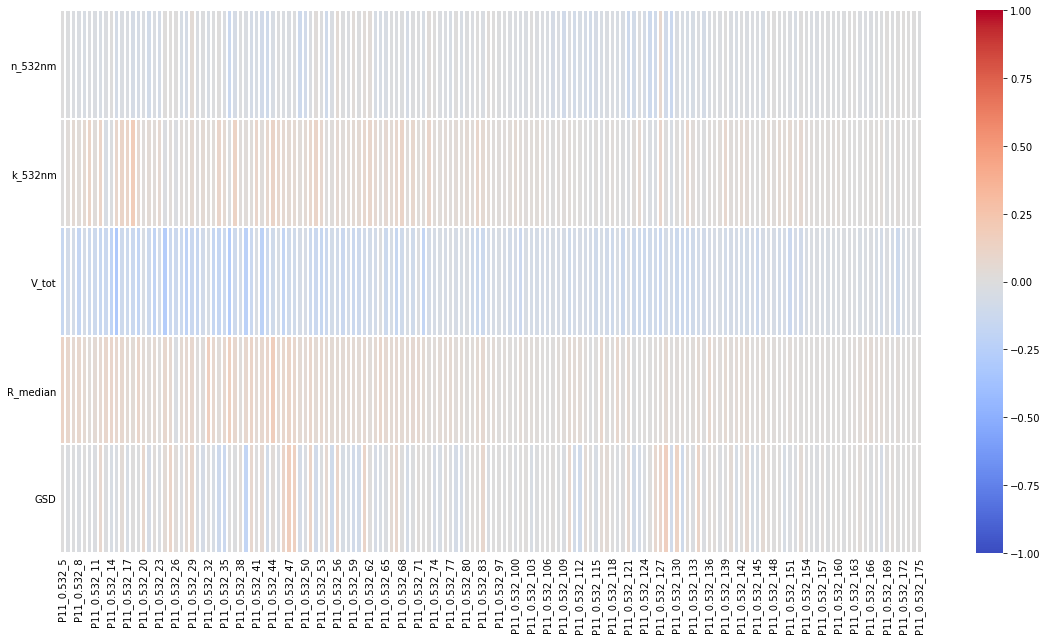

In [69]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

In [70]:
error_qoi = qoi_test - qoi_pred_test


KeyError: 'phase_3.0'

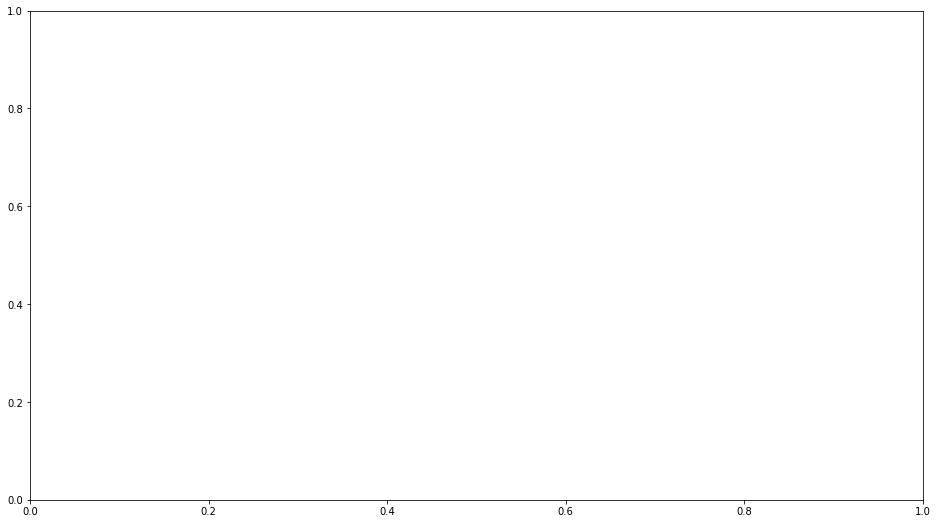

In [71]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in ['phase_3.0', 'phase_4.0', 'phase_5.0']:
    sns.distplot(error_qoi[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[0],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[1],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[2],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [ ]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error_qoi[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [ ]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [ ]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

In [ ]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(error_qoi[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [ ]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [ ]:
rel_error_qoi.abs().quantile(0.9)

In [ ]:
error_qoi

In [ ]:
statistic, p = scipy.stats.shapiro(standardise(error_qoi['P11_0.532_5']).values)

In [ ]:
p

In [ ]:
autoencoder.summary()

In [ ]:

presentation_plot_index = [0,1,3,4,5,6,7,8,9]

qoi_test.index.values

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    ax.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title('GSD=1.5, RI_n=1.5, RI_k=0.005',fontsize = 25)
#fig.align_labels()
ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result_all.jpg')

In [ ]:
qoi_test

In [ ]:
qoi_pred_test

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in presentation_plot_index:
    plot_test_data = ax.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = ax.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
    
    #plt.yscale('logit')

ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
ax.set_ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 
ax.set_title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
ax.legend(['Test data', 'Predicted test data'], fontsize = 16)
#ax.legend(loc='upper right', shadow=True,title='GMD', fontsize=16)
ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data__result.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for index in qoi_test.index.values:
    ax.plot(qoi_test.iloc[index],qoi_pred_test.iloc[index],'b*')
    
    #plt.yscale('logit')
    
    
ax.set_xlabel('Test data',fontsize = 25)
ax.set_ylabel('Predicted test data ',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

ax.axline([0, 0], [1, 1])


#fig.align_labels()
#ax.get_legend().get_title().set_fontsize('16')
fig.savefig(f'{plot_dir}/phase_data_correlation.jpg')

In [ ]:
model_dir

In [ ]:
history_file = model_dir+'/history_loss.csv'
history = pd.read_csv(history_file)
history


In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list(range(len(history['loss']))),history['loss'],'b*-',label='training')
ax.plot(list(range(len(history['val_loss']))),history['val_loss'],'r*-',label='validation')
    
ax.set_xlabel('Epoch',fontsize = 25)
ax.set_ylabel('Loss',fontsize = 25)
ax.tick_params(labelsize = 16)    
fig.tight_layout() 

fig.savefig(f'{plot_dir}/Loss_over_epoch.jpg')


In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_dir

In [ ]:
plot_model(autoencoder.encoder, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
plot_model(autoencoder.decoder, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(pd.DataFrame(r2_adj_T_qoi, columns = ['r2_adj']).T,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_qoi,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_qoi.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_test.columns)+3),qoi_pred_test.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_test.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([0, 0], [1,1])

plt.subplot2grid((7,3), (6,2), colspan=1, rowspan=1)

plt.plot(list(range(len(history['loss']))),history['loss'],'b*-',label='training')
plt.plot(list(range(len(history['val_loss']))),history['val_loss'],'r*-',label='validation')
    
plt.xlabel('Epoch',fontsize = 25)
plt.ylabel('Loss',fontsize = 25)
plt.tick_params(labelsize = 16)    


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_autoencoder_model.jpg')
